# XOR Example
(lecture date: Oct. 8; see chapter 6 (DLB) for details)

This simple example introduces **neurons**, **fully-connected (FC) layers** (aka linear layers), as well as our first non-linearity, i.e., a **rectified linear unit (ReLU)**.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

Let's define our **training** points, these are the inputs to the XOR function. Note that we add a one as the last dimension for reasons that will be clearer later.

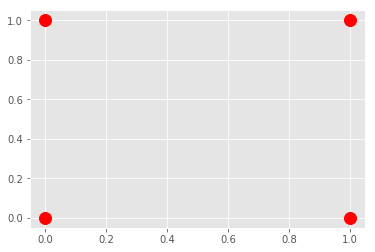

In [5]:
# XOR training points
X = np.array([
    [0,0,1], # 0,0 -> 0
    [0,1,1], # 0,1 -> 1
    [1,0,1], # 1,0 -> 1
    [1,1,1]])# 1,1 -> 0

plt.figure(figsize=(6,4))
plt.plot(X[:,0],X[:,1],'ro',markersize=12)

For every row in `X` we need a target. The target is the **output** of the XOR function.

In [6]:
y = np.array([0,1,1,0])

We aim to minimize the following quantity (mean-squared error - MSE)

$$ J(\theta) = 1/4 \sum_x (f^*(x) - f(x;\theta))^2 $$

where 

$$f(x;\theta) = \langle x,w\rangle + b$$ 

is a **linear model** and $\theta = [w,b]$. Lets try to do this with a least-squares solver first:

In [8]:
# Use a least-squares solver
w,_,_,_ = np.linalg.lstsq(X,y,rcond=None)
print(w)
print('Weight:', w[0:2])
print('Bias:', w[-1])

[-1.68915054e-16 -2.04995384e-16  5.00000000e-01]
Weight: [-1.68915054e-16 -2.04995384e-16]
Bias: 0.49999999999999983


Apparently this does not work, as the output will always be $0.5$ (which is the least-squares solution, but not the values that we want for our XOR). So, a simple linear model cannot do the job here. Just as a reminder, minimizing the MSE has indeed a (well-known) closed-form solution for this model.

In [21]:
# Solve using close-form solution 
# inv(X'*X)*X'*y
w = np.dot(
    np.matmul(
        np.linalg.inv(np.matmul(
            X.T,
            X)),
        X.T),
    y)
print('Weight:', w[0:2])
print('Bias:', w[-1])

Weight: [1.66533454e-16 5.55111512e-17]
Bias: 0.49999999999999983


Lets try an alternative, and make the model **non-linear**. It's easy to show that just stacking linear functions on top of each other, e.g., $g(x) = f_1(f_2(x))$ with $f_1,f_2$ linear would not work either, as the final model $g(x)$ would still be linear. 

Our goal is to have something like 

$$f(x;\theta) = \langle \phi(x), w\rangle +b$$

where $\phi(x)$ suitably transforms our features $x$ into a **representation** where the outer linear model would work.

In particular, we aim to implement 

$$f(x;W,c,w,b) = w^\top \max(0, W^\top x + c) + b$$

That is, the input goes (1) through one hidden layer with 2 units, then (2) through a ReLU (rectified linear unit) non-linearity and (3) finally through another linear layer with one unit.

In [10]:
import torch         # import pytorch
from torch import nn # import the neural network submodule from pytorch

### Linear layers

In [11]:
# Define a linear layer (FC layer) with 2 inputs and 1 output
ll = nn.Linear(2, 1, bias=False)
print('Weight of layer:', ll.weight.detach().numpy())

# Get a random tensor with 2 values
x = torch.randn(2)
print('Input:', x.numpy())

# Pass x through the linear layer
print('Output: {:.4f}'.format(ll(x).item()))

Weight of layer: [[-0.12819749  0.40015882]]
Input: [-0.300799   0.5595345]
Output: 0.2625


Lets quickly check the result, by computing the dot product $\langle w,x\rangle$:

In [12]:
a = ll.weight.data.numpy().flatten()
b = x.data.numpy()
print('Dot product:', (a*b).sum())
assert(np.abs(ll(x).item() -(a*b).sum())<1e-9)

Dot product: 0.26246434


In fact, we have now one neuron that takes 2 inputs and produces 1 output. Now, lets try to have two 2 neurons, each producing one output:

In [13]:
hl = nn.Linear(2,2, bias=False)
x = torch.randn(2)
print("Output:", hl(x))

print(hl.weight)

a = hl.weight.data.numpy()
print("Output 1: {:.4f}".format((a[0,:]*x.data.numpy()).sum()))
print("Output 2: {:.4f}".format((a[1,:]*x.data.numpy()).sum()))

Output: tensor([-0.9137, -0.2673])
Parameter containing:
tensor([[-0.4036,  0.6115],
        [ 0.3955,  0.2245]])
Output 1: -0.9137
Output 2: -0.2673


As we can see, the inputs are **connected to both neurons** and each neuron computes its own inner product. That's why we call such a layer a **fully-connected (FC) layer** in deep learning lingo.

Next, lets see how we can make $f(x;\theta)$ non-linear. We will do this by pushing the outputs of neurons through a non-linear function, in our case a **Rectified Linear Unit (ReLU)**.

### ReLU

Text(0.5,1,'Rectified Linear Unit (ReLU)')

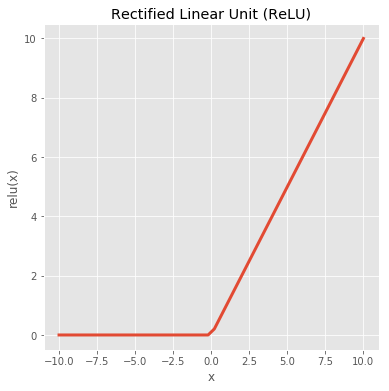

In [78]:
x = torch.from_numpy(np.linspace(-10,10)) # create 50 (default) linearly-spaced values in [-10,10]
y = torch.nn.functional.relu(x).numpy()   # apply the ReLU function to each of those 50 values separately

plt.figure(figsize=(6,6))
plt.plot(np.linspace(-10,10),y,linewidth=3)
plt.xlabel('x')
plt.ylabel('relu(x)')
plt.title('Rectified Linear Unit (ReLU)')

In [15]:
# Here's a combination of a linear layer + ReLU
ll = nn.Linear(2, 1, bias=False)
rl = nn.ReLU()
print('Weight of layer:', ll.weight.detach().numpy())
x = torch.randn(2)
print('Input:', x.numpy())
print('Output: {:.4f}'.format(ll(x).item()))
print('After ReLU {:.4f}'.format(rl(ll(x)).item()))

Weight of layer: [[-0.29807296 -0.6277993 ]]
Input: [ 1.0113567 -0.4613576]
Output: -0.0118
After ReLU 0.0000


Lets revisit the XOR example, but now we add a (hidden) layer with a non-linearity (ReLU). See pytorch documentation for more details on `nn.Sequential`.

In [17]:
net = nn.Sequential(
    nn.Linear(2,2,bias=True), # implements W'x + c
    nn.ReLU(),                # implements max(0, x)
    nn.Linear(2,1,bias=True)) # implements w'x + b

Lets set the network parameters by hand. Obviously, we are only going to do this once, as later we aim to **learn** them from training examples.

In [18]:
# see Chapter 6 for details
W = np.array([[1,1],[1,1]], dtype=np.float32)
c = np.array([[0,-1]],      dtype=np.float32)
w = np.array([[1,-2]],      dtype=np.float32)
b = np.array([0],           dtype=np.float32)

net[0].weight = torch.nn.Parameter(torch.from_numpy(W))
net[0].bias   = torch.nn.Parameter(torch.from_numpy(c))  
net[2].weight = torch.nn.Parameter(torch.from_numpy(w))
net[2].bias   = torch.nn.Parameter(torch.from_numpy(b))

In [19]:
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)


In [20]:
X = np.array([
    [0,0], 
    [0,1], 
    [1,0], 
    [1,1]],dtype=np.float32)

# push data through network
y = net(torch.from_numpy(X)) # Voila
print(y)

tensor([[ 0.],
        [ 1.],
        [ 1.],
        [ 0.]])


Ok, so we have learned that transforming our input into a representation that is **suitable**, allows to fit a linear model that produces the desired output. This theme of finding a **suitable representation** of the data will occur many, many times ...